AdvNLP - HW1

-Clarice Mottet

# Outline

Part 1: Rule-based Analysis using spaCy Matcher (2 points)
- Objective: Utilize spaCy's Matcher to classify movie reviews as positive or negative based on predefined linguistic rules.
- Tasks:
  1. Positive Reviews Rule Creation (0.5 point): Develop a rule using spaCy's Matcher to identify phrases commonly found in positive reviews. Justify your choice of patterns.
  2. Negative Reviews Rule Creation (0.5 point): Create a similar rule for detecting negative reviews. Explain the rationale behind the patterns selected.
  3. Reducing False Positives (1 point): Propose and implement a rule to minimize false positives in your classifications. Discuss the improvements observed.

Part 2: Machine Learning with TF-IDF and Logistic Regression (3 points)
- Objective: Build and evaluate a sentiment analysis model using TF-IDF vectorization and logistic regression.
- Tasks:
  1. Model Fitting (0.5 points): Train a logistic regression model on TF-IDF vectors of the movie reviews.
  2. Feature Importance Analysis (0.5 points): Identify and interpret the most influential features in your model.
  3. Preprocessing Improvements (1 point): Experiment with different preprocessing techniques of your training set to enhance model performance. Summarize the impact of these modifications.
  4. Word2Vec Embeddings (0.5 points each for a. and b.):
     - a. Implement sentence embedding using the mean of word vectors and retrain your logistic regression model.
     - b. Create sentence embeddings using TF-IDF weighted averages of word vectors and retrain the model. Compare this approach with the mean embedding technique. Comment

Part 3: Recurrent Neural Networks (RNN) with Word2Vec (4 points)
- Objective: Explore the application of RNNs for sentiment analysis, utilizing pre-trained Word2Vec embeddings.
- Tasks:
  1. RNN Implementation (2 point): Fit an RNN model with LSTM units using Word2Vec embeddings. Analyze and compare its performance with the TF-IDF based logistic regression model. Discuss any notable differences in results.
  2. Word2Vec Vectors Analysis:
     - Before and After Fine-Tuning (1 point): Examine the evolution of word vectors by comparing them before and after fine-tuning on the movie review dataset. Provide insights into the changes observed.
     - Visualization and Commentary (1 point): Visualize the embeddings of select words before and after fine-tuning using a tool like t-SNE or PCA. Comment on any patterns or shifts in word associations.

Submission Guidelines:
- Document your code, analysis, and findings in a Jupyter notebook. 1 point on code quality
- Include comments and markdown cells to explain your logic and interpretations at each step.

- Submit the notebook file via colab.
- Dataset: https://huggingface.co/datasets/rotten_tomatoes

In [4]:
#libraries

import pandas as pd
import numpy as np
import os

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import spacy
from spacy.matcher import Matcher
# Load English tokenizer, tagger, parser, and NER
nlp = spacy.load("en_core_web_sm")

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import spacy

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

path_ = r'/home/clarice/Documents/VSCode/Term2_AdvNLP/Homework1/AdvNLP_HW1/data'
os.listdir(path_)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clarice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/clarice/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clarice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['default_train_0000.parquet', 'default_test_0000.parquet']

In [25]:
#user defined functions

# Function to preprocess text
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    # Load NLTK's English stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Remove common words in both populations
    both_pop_rmv = ["like","make","film","movie","one","little","good","enough","funny","many","much"]
    tokens = [word for word in tokens if word.lower() not in both_pop_rmv]
    
    # # Stem using NLTK's Porter stemmer
    # Initialize NLTK's Porter stemmer
    # porter_stemmer = PorterStemmer()

    # stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]

    # # Lemmatize using spaCy
    # doc = nlp(" ".join(stemmed_tokens))
    # lemmatized_tokens = [token.lemma_ for token in doc]

    # Join the tokens back into a single string
    clean_text = " ".join(tokens)
    
    return clean_text


In [26]:
#import and process data

df_train = pd.read_parquet(path_+'//'+'default_train_0000.parquet')
df_test = pd.read_parquet(path_+'//'+'default_test_0000.parquet')

print("df_train size", len(df_train['text']))
# print(df_train.head())
print("df_test size", len(df_test['text']))
# print(df_test.head())

#clean data

df_train['text'] = df_train['text'].str.lower().str.strip()
df_test['text'] = df_test['text'].str.lower().str.strip()

# Apply preprocessing to the 'text' column
df_train['text_clean'] = df_train['text'].apply(preprocess_text)
df_test['text_clean'] = df_test['text'].apply(preprocess_text)

# print(df_train.head())

df_train size 8530
df_test size 1066


# Part 1: Rule-based Analysis using spaCy Matcher (2 points)
- Objective: Utilize spaCy's Matcher to classify movie reviews as positive or negative based on predefined linguistic rules.
- Tasks:
  1. Positive Reviews Rule Creation (0.5 point): Develop a rule using spaCy's Matcher to identify phrases commonly found in positive reviews. Justify your choice of patterns.
  2. Negative Reviews Rule Creation (0.5 point): Create a similar rule for detecting negative reviews. Explain the rationale behind the patterns selected.
  3. Reducing False Positives (1 point): Propose and implement a rule to minimize false positives in your classifications. Discuss the improvements observed.

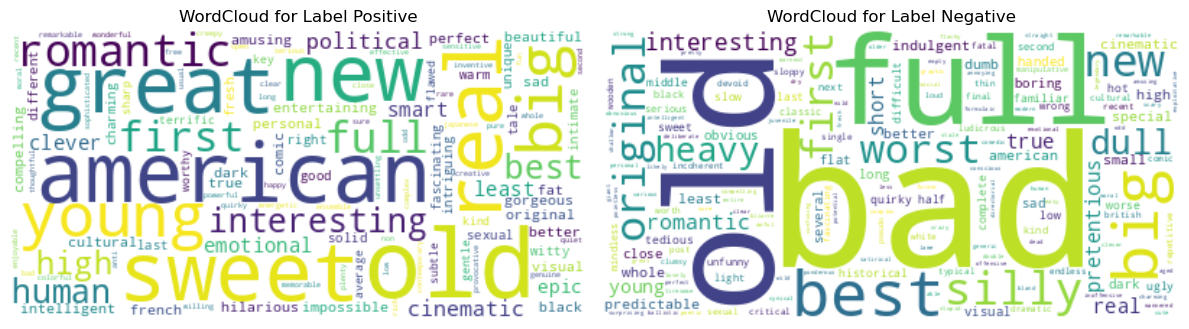

In [27]:
#create a word cloud of adjectives to create a vocabulary for matcher

stop_words = set(stopwords.words('english'))
labels = {0: 'Negative', 1: 'Positive'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(df_train['text_clean'], df_train['label']):
    doc = nlp(text)
    adjectives = [token.text for token in doc if token.pos_ == 'ADJ']
    label_data[label] += ' '.join(adjectives)

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create 1x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()


In [28]:
# Initialize Matcher
matcher = Matcher(nlp.vocab)

# Define patterns for positive and negative reviews
positive_patterns = [
    [{"LOWER": "amazing"}],
    [{"LOWER": "fantastic"}],
    [{"LOWER": "great"}],
    [{"LOWER": "loved"}, {"POS": "VERB"}],
    [{"LOWER": "excellent"}],
    [{"LOWER": "sweet"}],
    [{"LOWER": "interesting"}],
    [{"LOWER": "perfect"}],
    [{"LOWER": "amusing"}],
    [{"LOWER": "beautiful"}],
    [{"LOWER": "unique"}],
    [{"LOWER": "terrific"}],
    [{"LOWER": "charming"}],
    [{"LOWER": "clever"}],
    [{"LOWER": "intelligent"}],
    [{"LOWER": "gorgeous"}],
    [{"LOWER": "witty"}]
]

negative_patterns = [
    [{"LOWER": "terrible"}],
    [{"LOWER": "awful"}],
    [{"LOWER": "hate"}, {"POS": "VERB"}],
    [{"LOWER": "dislike"}, {"POS": "VERB"}],
    [{"LOWER": "waste"}, {"LOWER": "of"}, {"LOWER": "time"}],
    [{"LOWER": "silly"}],
    [{"LOWER": "bad"}],
    [{"LOWER": "old"}],
    [{"LOWER": "full"}],
    [{"LOWER": "dull"}],
    [{"LOWER": "worst"}],
    [{"LOWER": "heavy"}],
    [{"LOWER": "least"}],
    [{"LOWER": "predictable"}],
    [{"LOWER": "unfunny"}],
    [{"LOWER": "tedious"}],
    [{"LOWER": "bad"}],
    [{"LOWER": "boring"}]
]

# Add patterns to matcher
for pattern in positive_patterns:
    matcher.add("Positive", [pattern])

for pattern in negative_patterns:
    matcher.add("Negative", [pattern])

# Function to classify review
def classify_review(text):
    doc = nlp(text)
    matches = matcher(doc)
    if any(match[0] == nlp.vocab.strings["Positive"] for match in matches):
        return 1  # Positive
    elif any(match[0] == nlp.vocab.strings["Negative"] for match in matches):
        return 0  # Negative
    else:
        return None  # Neutral or not determined

# Apply classification function to each review
df_train['predicted_label'] = df_train['text'].apply(classify_review)

df_view = df_train[df_train['predicted_label'].isna()].copy()
print("df_train no match",len(df_view['text']))


df_train no match 7041


- Tasks:
  1. Positive Reviews Rule Creation (0.5 point): Develop a rule using spaCy's Matcher to identify phrases commonly found in positive reviews. Justify your choice of patterns.
  2. Negative Reviews Rule Creation (0.5 point): Create a similar rule for detecting negative reviews. Explain the rationale behind the patterns selected.
  3. Reducing False Positives (1 point): Propose and implement a rule to minimize false positives in your classifications. Discuss the improvements observed.

To determine an initial positive and negative rule creation, I cleaned the text data to lowercase everything and remove stopwords. Next, I created a list to remove common terms found in both positive review and negative review populations. Words in the below list appeared often in both populations but do no lend information as to whether a review is positive or negative and are removed. ["like","make","film","movie","one","little","good","enough","funny","many","much"]
Next I only looked at adjective words to drill down to terms than can be used to indicate positive or negative review in the wordcloud and developed an initial vocabulary.

With more time to work on this project, I would create a broader vocabularly to cover the full population but with time constraint, I've only managed to cover approximately 1,500 reviews out of approximately 8,500.

In [37]:
#Analyze confusion matrix

df_pred = df_train[df_train['predicted_label'].notna()].copy()
df_pred.reset_index(drop = True, inplace = True)

cndn = (df_pred['label']==1)&(df_pred['predicted_label']==1)
print("True Positive Review:", len(df_pred[cndn]))

cndn = (df_pred['label']==1)&(df_pred['predicted_label']==0)
print("False Positive Review:", len(df_pred[cndn]['text']))

cndn = (df_pred['label']==0)&(df_pred['predicted_label']==0)
print("True Negative Review:", len(df_pred[cndn]['text']))

cndn = (df_pred['label']==0)&(df_pred['predicted_label']==1)
print("False Negative Review:", len(df_pred[cndn]['text']))

df_false_pos = df_train[(df_train['label']==1)&(df_train['predicted_label']==0)].copy()
print(df_false_pos['text_clean'].head())

df_false_pos.to_excel(path_ + '//' + '')

True Positive Review: 470
False Positive Review: 220
True Negative Review: 568
False Negative Review: 231
27     idealistic love story brings latent 15-year-ol...
39     bond outings recent years , stunts outlandish ...
49     may spoofing easy target -- old '50 's giant c...
152    's old story , lively script , sharp acting pa...
160    faithful presumes book 's twin premises -- bec...
Name: text_clean, dtype: object


# Part 2: Machine Learning with TF-IDF and Logistic Regression (3 points)
- Objective: Build and evaluate a sentiment analysis model using TF-IDF vectorization and logistic regression.
- Tasks:
  1. Model Fitting (0.5 points): Train a logistic regression model on TF-IDF vectors of the movie reviews.
  2. Feature Importance Analysis (0.5 points): Identify and interpret the most influential features in your model.
  3. Preprocessing Improvements (1 point): Experiment with different preprocessing techniques of your training set to enhance model performance. Summarize the impact of these modifications.
  4. Word2Vec Embeddings (0.5 points each for a. and b.):
     - a. Implement sentence embedding using the mean of word vectors and retrain your logistic regression model.
     - b. Create sentence embeddings using TF-IDF weighted averages of word vectors and retrain the model. Compare this approach with the mean embedding technique. Comment

# Part 3: Recurrent Neural Networks (RNN) with Word2Vec (4 points)
- Objective: Explore the application of RNNs for sentiment analysis, utilizing pre-trained Word2Vec embeddings.
- Tasks:
  1. RNN Implementation (2 point): Fit an RNN model with LSTM units using Word2Vec embeddings. Analyze and compare its performance with the TF-IDF based logistic regression model. Discuss any notable differences in results.
  2. Word2Vec Vectors Analysis:
     - Before and After Fine-Tuning (1 point): Examine the evolution of word vectors by comparing them before and after fine-tuning on the movie review dataset. Provide insights into the changes observed.
     - Visualization and Commentary (1 point): Visualize the embeddings of select words before and after fine-tuning using a tool like t-SNE or PCA. Comment on any patterns or shifts in word associations.